# Machine Learning Engineer Nanodegree - Capstone Project
## PART 5: Deep Learning Models

**Author:** Giacomo Sarchioni

In [2]:
# Module imports
import pickle as pkl
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from roc_chart import ROCChart
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from roc_chart import ROCChart
from sklearn.externals import joblib
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Conv1D, MaxPooling1D, Dense, Embedding, Flatten, Dropout, LSTM, GRU
from keras.models import load_model
from gensim.models import Word2Vec

random_seed = 42

## Import data

In [3]:
# Load reviews
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)
    
# Load indexes
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

In [5]:
# Extract scores
scores = sentiment_reviews.adj_score.values

# Extract non-test and test scores
non_test_scores = scores[indexes['non_test']]
test_scores = scores[indexes['test']]

# Extract train and validation scores
train_scores = non_test_scores[indexes['train']]
val_scores = non_test_scores[indexes['val']]

In [7]:
# Transform scores into categorical
scores_cat = keras.utils.to_categorical(scores,2)

# Extract non-test and test scores
non_test_scores_cat = scores_cat[indexes['non_test']]
test_scores_cat = scores_cat[indexes['test']]

# Extract train and validation scores
train_scores_cat = non_test_scores_cat[indexes['train']]
val_scores_cat = non_test_scores_cat[indexes['val']]

In [8]:
# Extract parser_one_reviews 
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

# Extract non test parser two reviews and scores
non_test_parser_one_reviews = parser_one_reviews[indexes['non_test']]
test_parser_one_reviews = parser_one_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_one_reviews = non_test_parser_one_reviews[indexes['train']]
val_parser_one_reviews = non_test_parser_one_reviews[indexes['val']]

#### Import log reg benchmark model

In [9]:
# Load log reg benchmark
bmk_log_reg = joblib.load('bmk_models/bmk_log_reg.pkl')

# Bmk Log Reg predictions on validation data
bmk_log_reg_pred = bmk_log_reg.predict(val_parser_one_reviews)

## Statistics on reviews' max length

In [10]:
# Extract parser one reviews
parser_one_reviews = sentiment_reviews.loc[:,'parser_one'].values

# Reviews' lenght
parser_one_reviews_length = pd.Series([len(x.split()) for x in parser_one_reviews])

In [11]:
print("Statisics for parser_one reviews' length")
parser_one_reviews_length.describe()

Statisics for parser_one reviews' length


count    363824.000000
mean         78.942821
std          75.788450
min           2.000000
25%          34.000000
50%          56.000000
75%          96.000000
max        2486.000000
dtype: float64

## Conv1D/RNN with Keras embedding

In this case I will need to use *parser_one* data. I will use `keras` built-in `Tokenizer` to assign word to indexes.

In [12]:
# Extract non test parser two reviews and scores
non_test_parser_one_reviews = parser_one_reviews[indexes['non_test']]
test_parser_one_reviews = parser_one_reviews[indexes['test']]

# Extract train and validation parser-two reviews
train_parser_one_reviews = non_test_parser_one_reviews[indexes['train']]
val_parser_one_reviews = non_test_parser_one_reviews[indexes['val']]

In [62]:
# Initialise keras tokenizer
keras_tokenizer = Tokenizer()

# Fit keras tokenizer
keras_tokenizer.fit_on_texts(train_parser_one_reviews)

In [63]:
# Tokenise train, val and test parser_zero reviews
tokenised_train = keras_tokenizer.texts_to_sequences(train_parser_one_reviews)
tokenised_val = keras_tokenizer.texts_to_sequences(val_parser_one_reviews)
tokenised_test = keras_tokenizer.texts_to_sequences(test_parser_one_reviews)

In [64]:
# Define max_len of reviews
max_len = 50

# Transform reviews into sequences using pad_sequences
padded_train = pad_sequences(tokenised_train, maxlen=max_len, padding='post')
padded_val = pad_sequences(tokenised_val, maxlen=max_len, padding='post')
padded_test = pad_sequences(tokenised_test, maxlen=max_len, padding='post')

In [211]:
# Size of tokenizer vocabular
len(keras_tokenizer.word_index)

106683

#### Conv1D model

In [152]:
# Define model checkpoint
keras_conv_ckpt = ModelCheckpoint('deep_learning_models/keras_embedding/keras_conv.hdf5', 
                                   save_best_only=True, verbose=1)

In [168]:
# Define conv1d with Keras embedding
keras.backend.clear_session()
keras_conv_model = Sequential()
keras_conv_model.add(Embedding(len(keras_tokenizer.word_index)+1,
                               50,
                               input_length=max_len))
keras_conv_model.add(Conv1D(16, 3, strides=2, padding='same', activation='relu'))
keras_conv_model.add(MaxPooling1D(padding='same'))
keras_conv_model.add(Conv1D(32, 1, strides=1, padding='same', activation='relu'))
keras_conv_model.add(MaxPooling1D(padding='same'))
keras_conv_model.add(Flatten())
keras_conv_model.add(Dense(32, activation='tanh'))
keras_conv_model.add(Dense(2, activation='softmax'))
keras_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            5334200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            2416      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 32)            544       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                7200      
__________

In [169]:
# Compile the model
keras_conv_model.compile(optimizer='rmsprop',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Fit the model
# keras_conv_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
#                      validation_data=(padded_val, val_scores_cat),
#                      callbacks=[keras_conv_ckpt], 
#                      epochs=5)

In [170]:
# Load checkpoint weights
keras_conv_model.load_weights('deep_learning_models/keras_embedding/keras_embed_conv.hdf5')

In [156]:
# Get prediction of conv model on vaidation data
val_conv_pred = keras_conv_model.predict_classes(padded_val)

#### RNN models

I will try two possible architectures for RNN models, i.e.:

* **LSTM**;
* **GRU**.

##### LSTM

In [157]:
# Define model checkpoint
keras_lstm_ckpt = ModelCheckpoint('deep_learning_models/keras_embedding/keras_lstm.hdf5', 
                                   save_best_only=True, verbose=1)

In [171]:
# Define LSTM network with Keras embedding
keras.backend.clear_session()
keras_lstm_model = Sequential()
keras_lstm_model.add(Embedding(len(keras_tokenizer.word_index)+1, 50,
                               input_length=max_len))
keras_lstm_model.add(LSTM(64))
keras_lstm_model.add(Dense(2, activation='softmax'))
keras_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            5334200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 5,363,770
Trainable params: 5,363,770
Non-trainable params: 0
_________________________________________________________________


In [172]:
# Compile the model
keras_lstm_model.compile(optimizer='rmsprop',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Fit the model
# keras_lstm_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
#                      validation_data=(padded_val, val_scores_cat),
#                      callbacks=[keras_lstm_ckpt], 
#                      epochs=5)

In [173]:
# Load checkpoint weights
keras_lstm_model.load_weights('deep_learning_models/keras_embedding/keras_lstm.hdf5')

In [161]:
# Get prediction of lstm model on test data
val_lstm_pred = keras_lstm_model.predict_classes(padded_val)

##### GRU

In [174]:
# Define model checkpoint
keras_gru_ckpt = ModelCheckpoint('deep_learning_models/keras_embedding/keras_gru.hdf5', 
                                 save_best_only=True, verbose=1)

In [175]:
# Define GRU network with Keras embedding
keras.backend.clear_session()
keras_gru_model = Sequential()
keras_gru_model.add(Embedding(len(keras_tokenizer.word_index)+1, 50,
                              input_length=max_len))
keras_gru_model.add(GRU(64))
keras_gru_model.add(Dense(2, activation='softmax'))
keras_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            5334200   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                22080     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 5,356,410
Trainable params: 5,356,410
Non-trainable params: 0
_________________________________________________________________


In [176]:
# Compile the model
keras_gru_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Fit the model
# keras_gru_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
#                     validation_data=(padded_val, val_scores_cat),
#                     callbacks=[keras_gru_ckpt], 
#                     epochs=5)

Train on 294696 samples, validate on 32745 samples
Epoch 1/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2432 - acc: 0.9037
Epoch 00001: val_loss improved from inf to 0.25545, saving model to deep_learning_models/keras_embedding/keras_gru.hdf5
294696/294696 [==============================] - 107s 363us/step - loss: 0.2432 - acc: 0.9037 - val_loss: 0.2554 - val_acc: 0.9150
Epoch 2/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.1934 - acc: 0.9231
Epoch 00002: val_loss improved from 0.25545 to 0.19153, saving model to deep_learning_models/keras_embedding/keras_gru.hdf5
294696/294696 [==============================] - 106s 361us/step - loss: 0.1935 - acc: 0.9231 - val_loss: 0.1915 - val_acc: 0.9250
Epoch 3/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.1694 - acc: 0.9329
Epoch 00003: val_loss did not improve
294696/294696 [==============================] - 107s 362us/step - loss: 0.1694 - acc: 0.9329 - val_loss: 0.1933 - va

In [177]:
# Load checkpoint weights
keras_gru_model.load_weights('deep_learning_models/keras_embedding/keras_gru.hdf5')

In [178]:
# Get prediction of lstm model on test data
val_gru_pred = keras_gru_model.predict_classes(padded_val)

AUC score for Bmk Log Reg is 0.8609
AUC score for Conv1D Keras embedding is 0.8528
AUC score for LSTM Keras embedding is 0.8485
AUC score for GRU Keras Embedding is 0.8474


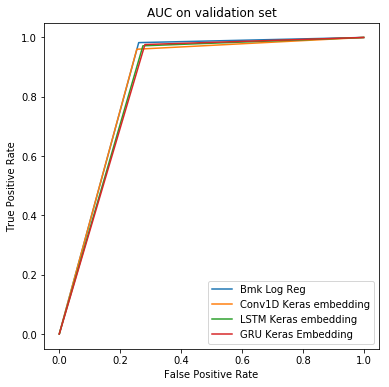

In [179]:
# Print comparison chart
comparison_chart = ROCChart(val_scores,
                            [bmk_log_reg_pred,
                             val_conv_pred,
                             val_lstm_pred,
                             val_gru_pred],
                            ['Bmk Log Reg',
                             'Conv1D Keras embedding',
                             'LSTM Keras embedding',
                             'GRU Keras Embedding'],
                            'AUC on validation set')
comparison_chart.plot()

## Conv1D/RNN with Word2vec vectors

In [180]:
# Load word2vec model
sgram_word2vec_model = Word2Vec.load('word2vec_models/default_sgram_word2vec.hdf5')

In [181]:
# Extract words in word2vec model
sgram_word2vec_words = set(sgram_word2vec_model.wv.index2word)

In [182]:
# Initialise zero array
embedding_matrix = np.zeros((len(keras_tokenizer.word_index)+1, 300))
embedding_matrix.shape

(106684, 300)

In [183]:
# Extract index2word dictionary from tokenise
keras_tokenizer_index2word = {i:k for k,i in keras_tokenizer.word_index.items()}

In [184]:
# Add word2vec to embedding matrix
for i in range(embedding_matrix.shape[0]):
    if i != 0 and keras_tokenizer_index2word[i] in sgram_word2vec_words:
        embedding_matrix[i] = sgram_word2vec_model.wv[keras_tokenizer_index2word[i]]

#### Conv1D model

In [191]:
# Define model checkpoint
w2v_conv_ckpt = ModelCheckpoint('deep_learning_models/word2vec_embedding/w2v_conv.hdf5', 
                                save_best_only=True, verbose=1)

In [192]:
# Define conv1d with Keras embedding
keras.backend.clear_session()
w2v_conv_model = Sequential()
w2v_conv_model .add(Embedding(len(keras_tokenizer.word_index)+1, 300,
                              input_length=max_len,
                              weights=[embedding_matrix], 
                              trainable=False))
w2v_conv_model.add(Conv1D(16, 3, strides=2, padding='same', activation='relu'))
w2v_conv_model.add(MaxPooling1D(padding='same'))
w2v_conv_model.add(Conv1D(32, 1, strides=1, padding='same', activation='relu'))
w2v_conv_model.add(MaxPooling1D(padding='same'))
w2v_conv_model.add(Flatten())
w2v_conv_model.add(Dense(32, activation='tanh'))
w2v_conv_model.add(Dense(2, activation='softmax'))
w2v_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           32005200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            14416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 32)            544       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                7200      
__________

In [193]:
# Compile the model
w2v_conv_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Fit the model
# w2v_conv_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
#                    validation_data=(padded_val, val_scores_cat),
#                    callbacks=[w2v_conv_ckpt], 
#                    epochs=5)

Train on 294696 samples, validate on 32745 samples
Epoch 1/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2593 - acc: 0.8931
Epoch 00001: val_loss improved from inf to 0.29111, saving model to deep_learning_models/word2vec_embedding/w2v_conv.hdf5
294696/294696 [==============================] - 14s 47us/step - loss: 0.2593 - acc: 0.8931 - val_loss: 0.2911 - val_acc: 0.8898
Epoch 2/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2067 - acc: 0.9173
Epoch 00002: val_loss improved from 0.29111 to 0.19861, saving model to deep_learning_models/word2vec_embedding/w2v_conv.hdf5
294696/294696 [==============================] - 14s 46us/step - loss: 0.2066 - acc: 0.9173 - val_loss: 0.1986 - val_acc: 0.9196
Epoch 3/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.1927 - acc: 0.9233
Epoch 00003: val_loss did not improve
294696/294696 [==============================] - 13s 45us/step - loss: 0.1927 - acc: 0.9233 - val_loss: 0.2030 - val_

In [194]:
# Load checkpoint weights
w2v_conv_model.load_weights('deep_learning_models/word2vec_embedding/w2v_conv.hdf5')

In [195]:
# Get prediction of conv model on test data
val_w2v_conv_pred = w2v_conv_model.predict_classes(padded_val)

#### RNN models

##### LSTM

In [196]:
# Define model checkpoint
w2v_lstm_ckpt = ModelCheckpoint('deep_learning_models/word2vec_embedding/w2v_lstm.hdf5', 
                                save_best_only=True, verbose=1)

In [197]:
# Define LSTM network with Word2vec embedding
keras.backend.clear_session()
w2v_lstm_model = Sequential()
w2v_lstm_model.add(Embedding(len(keras_tokenizer.word_index)+1, 300,
                             input_length=max_len,
                             weights=[embedding_matrix], 
                             trainable=False))
w2v_lstm_model.add(LSTM(64))
w2v_lstm_model.add(Dense(2, activation='softmax'))
w2v_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           32005200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 32,098,770
Trainable params: 93,570
Non-trainable params: 32,005,200
_________________________________________________________________


In [198]:
# Compile the model
w2v_lstm_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Fit the model
# w2v_lstm_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
#                    validation_data=(padded_val, val_scores_cat),
#                    callbacks=[w2v_lstm_ckpt], 
#                    epochs=5)

Train on 294696 samples, validate on 32745 samples
Epoch 1/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2775 - acc: 0.8868
Epoch 00001: val_loss improved from inf to 0.26232, saving model to deep_learning_models/word2vec_embedding/w2v_lstm.hdf5
294696/294696 [==============================] - 126s 428us/step - loss: 0.2775 - acc: 0.8868 - val_loss: 0.2623 - val_acc: 0.8927
Epoch 2/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2151 - acc: 0.9126
Epoch 00002: val_loss improved from 0.26232 to 0.20683, saving model to deep_learning_models/word2vec_embedding/w2v_lstm.hdf5
294696/294696 [==============================] - 126s 429us/step - loss: 0.2151 - acc: 0.9126 - val_loss: 0.2068 - val_acc: 0.9176
Epoch 3/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.1862 - acc: 0.9248
Epoch 00003: val_loss did not improve
294696/294696 [==============================] - 126s 428us/step - loss: 0.1862 - acc: 0.9248 - val_loss: 0.2164 

In [199]:
# Load checkpoint weights
w2v_lstm_model.load_weights('deep_learning_models/word2vec_embedding/w2v_lstm.hdf5')

In [200]:
# Get prediction of lstm model on test data
val_w2v_lstm_pred = w2v_lstm_model.predict_classes(padded_val)

##### GRU

In [202]:
# Define model checkpoint
w2v_gru_ckpt = ModelCheckpoint('deep_learning_models/word2vec_embedding/w2v_gru.hdf5', 
                               save_best_only=True, verbose=1)

In [203]:
# Define LSTM network with Word2vec embedding
keras.backend.clear_session()
w2v_gru_model = Sequential()
w2v_gru_model.add(Embedding(len(keras_tokenizer.word_index)+1, 300,
                            input_length=max_len,
                            weights=[embedding_matrix], 
                            trainable=False))
w2v_gru_model.add(GRU(64))
w2v_gru_model.add(Dense(2, activation='softmax'))
w2v_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           32005200  
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                70080     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 32,075,410
Trainable params: 70,210
Non-trainable params: 32,005,200
_________________________________________________________________


In [204]:
# Compile the model
w2v_gru_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Fit the model
w2v_gru_model.fit(x=padded_train, y=train_scores_cat, batch_size=256,
                  validation_data=(padded_val, val_scores_cat),
                  callbacks=[w2v_gru_ckpt], 
                  epochs=5)

Train on 294696 samples, validate on 32745 samples
Epoch 1/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2707 - acc: 0.8891
Epoch 00001: val_loss improved from inf to 0.23659, saving model to deep_learning_models/word2vec_embedding/w2v_gru.hdf5
294696/294696 [==============================] - 100s 339us/step - loss: 0.2707 - acc: 0.8891 - val_loss: 0.2366 - val_acc: 0.9116
Epoch 2/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9182
Epoch 00002: val_loss improved from 0.23659 to 0.19113, saving model to deep_learning_models/word2vec_embedding/w2v_gru.hdf5
294696/294696 [==============================] - 100s 339us/step - loss: 0.2009 - acc: 0.9182 - val_loss: 0.1911 - val_acc: 0.9235
Epoch 3/5
294656/294696 [============================>.] - ETA: 0s - loss: 0.1791 - acc: 0.9274
Epoch 00003: val_loss improved from 0.19113 to 0.17483, saving model to deep_learning_models/word2vec_embedding/w2v_gru.hdf5
294696/294696 [=============

In [205]:
# Load checkpoint weights
w2v_gru_model.load_weights('deep_learning_models/word2vec_embedding/w2v_gru.hdf5')

In [206]:
# Get prediction of gru model on validation data
val_w2v_gru_pred = w2v_gru_model.predict_classes(padded_val)

AUC score for Bmk Log Reg is 0.8609
AUC score for Conv1D Word2vec embedding is 0.8193
AUC score for LSTM Word2vec embedding is 0.8566
AUC score for GRU Word2vec Embedding is 0.8755


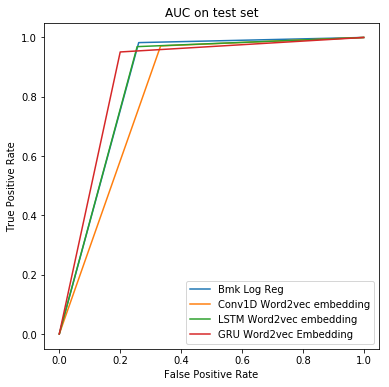

In [210]:
# Print comparison chart
comparison_chart = ROCChart(val_scores,
                            [bmk_log_reg_pred, 
                             val_w2v_conv_pred, 
                             val_w2v_lstm_pred, 
                             val_w2v_gru_pred],
                            ['Bmk Log Reg',
                             'Conv1D Word2vec embedding',
                             'LSTM Word2vec embedding',
                             'GRU Word2vec Embedding'],
                            'AUC on test set')
comparison_chart.plot()